# Boosting

## Adaboost

In [76]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor

In [4]:
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']
# カテゴリ変数の特徴量を整数に変換する
oe = OrdinalEncoder()
# numpyからdfの形に変換
oe.set_output(transform='pandas')
X = oe.fit_transform(X)
# トレーニングデータとテストデータを7:3に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

adaboost AUC: 0.9375


<BarContainer object of 13 artists>

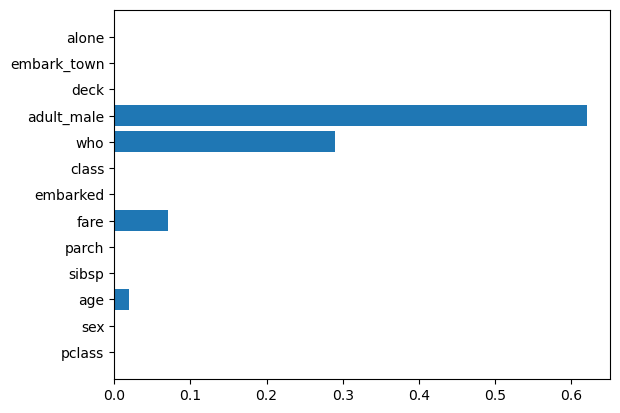

In [10]:
# 特徴量の重要度
# ada.feature_importances_
plt.barh(X.columns, ada.feature_importances_)

## 勾配ブースティング 回帰

In [30]:
class MyGradientBoostingRegressor:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = [] # 弱学習器を格納
        
    def fit(self, X, y):
        # 平均が最も損失を小さくする
        self.F0 = y.mean()
        Fb = self.F0
        
        for _ in range(self.n_estimators):
            # 残差を計算
            r = y - Fb
            # 弱学習器学習
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r) # 正解データは残差r
            weight = estimator.predict(X)
            # shrinkage(学習率)をかけて足し合わせていく
            # この時weightはNumPyArrayなので，Fbもイテレーション後はNumPyArrayになる
            Fb += self.learning_rate * weight
            self.estimators.append(estimator)
            
    def predict(self, X):
        Fb = self.F0
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
            
        return Fb

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

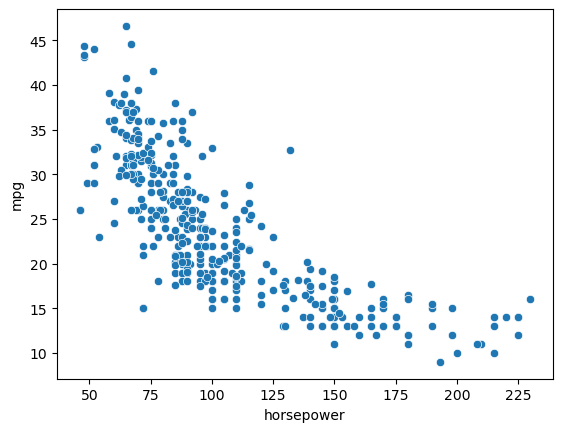

In [31]:
# データ準備
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
X = df['horsepower'].values.reshape(-1, 1)
y = df['mpg'].values
sns.scatterplot(x=df['horsepower'], y=df['mpg'])

In [36]:
my_gbr = MyGradientBoostingRegressor()
my_gbr.fit(X, y)
my_gbr.predict(X)[:10]

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562])

### sklearnのGradientBoostingRegressorを使う

In [45]:
lr = 0.03
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=lr, random_state=0).fit(X, y)

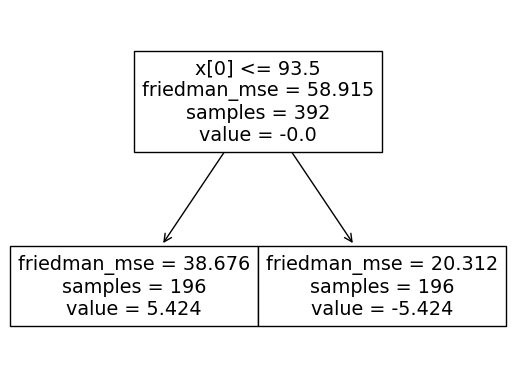

In [46]:
# 決定木で確認
model = gbr.estimators_[1][0]
_ = plot_tree(model)

In [48]:
results = []
idx = 0
for t in gbr.estimators_:
    result = t[0].predict([X[idx]])
    results.append(result*lr)    

In [49]:
F0 = np.mean(y)
Fb = F0 + np.cumsum(results)

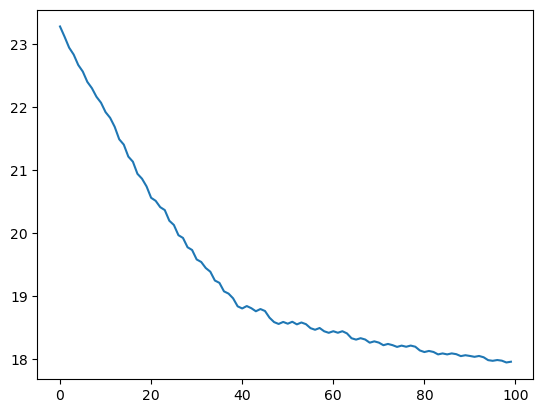

In [53]:
plt.plot(Fb)

## 勾配ブースティング　　分類

In [59]:
model = DecisionTreeRegressor(max_depth=1, random_state=0).fit(X, y)
# それぞれのXのデータがどの葉に落ちるのかを取得することができる
model.apply(X)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,

In [62]:
model.tree_.value

array([[[23.44591837]],

       [[29.0377551 ]],

       [[17.85408163]]])

[Text(0.5, 0.75, 'x[0] <= 93.5\nsquared_error = 60.763\nsamples = 392\nvalue = 23.446'),
 Text(0.25, 0.25, 'squared_error = 38.676\nsamples = 196\nvalue = 29.038'),
 Text(0.75, 0.25, 'squared_error = 20.312\nsamples = 196\nvalue = 17.854')]

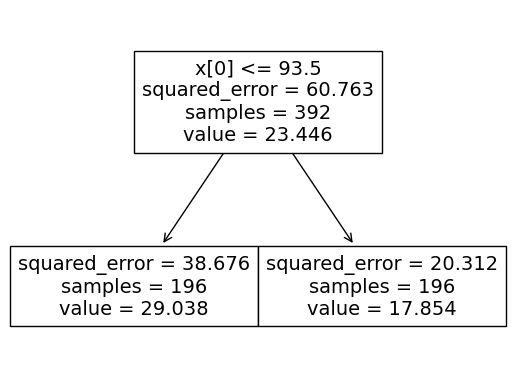

In [64]:
plot_tree(model)

In [73]:
class MyGradientBoostingClassifier:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = [] # 弱学習器を格納
        
    def fit(self, X, y):
        # 平均が最も損失を小さくする
        self.F0 = np.log(y.mean()/(1-y.mean()))
        F0 = np.full(len(y), self.F0)
        Fb = F0
        
        for _ in range(self.n_estimators):
            # 残差を計算
            p = 1 / (1 + np.exp(-Fb))
            r = y - p
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r) # 正解データは残差r(残差rを目的変数にする)
            X_leafs = estimator.apply(X)
            leaf_ids = np.unique(X_leafs)
            for leaf_id in leaf_ids:
                # 弱学習器の出力の値を計算
                fltr = X_leafs == leaf_id
                num = r[fltr].sum()
                den = (p[fltr]*(1-p[fltr])).sum()
                estimator_pred_proba = num / den
                # 弱学習器の出力を上書き
                estimator.tree_.value[leaf_id, 0, 0] = estimator_pred_proba
                # 当該データのFbを更新
                Fb[fltr] += self.learning_rate * estimator_pred_proba
                
            self.estimators.append(estimator)
            
    def predict_proba(self, X):
        Fb = np.full(X.shape[0], self.F0)
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
            
        return 1 / (1 + np.exp(-Fb))
        

In [75]:
my_gbc = MyGradientBoostingClassifier()
my_gbc.fit(X_train, y_train)
my_gbc.predict_proba(X_test)

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

## sklearnのGradientBoostingClassifierを使う

In [82]:
gbc = GradientBoostingClassifier(learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0).fit(X_train, y_train)
# gbc.predict_proba(X_test)[:, 1] == my_gbc.predict_proba(X_test)
print(f"grad boost AUC: {roc_auc_score(y_test, gbc.predict_log_proba(X_test)[:, 1])}")

grad boost AUC: 0.9407051282051282


In [88]:
results = []
for t in gbc.estimators_:
    result = 0.03 * t[0].predict([X_test.iloc[0]])
    results.append(result)

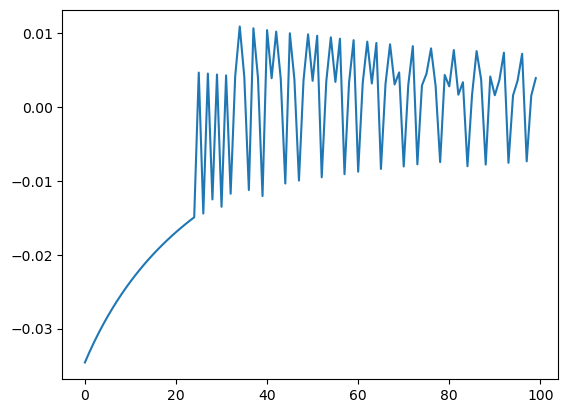

In [89]:
plt.plot(results)

In [91]:
F0 = np.log(y_train.mean()/(1-y_train.mean()))
Fb = F0 + np.cumsum(results)[-1]
predict = 1 / (1 + np.exp(-Fb))
predict

0.551434197251246

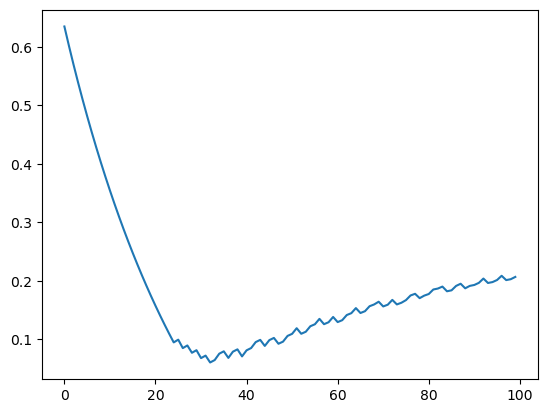

In [93]:
plt.plot(np.cumsum(results)+F0)